In [161]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import math
import copy
from datetime import datetime
from scipy.interpolate import splprep, splev
from shapely import Polygon, Point, LineString


In [4]:
import nbformat

# Load the notebook
with open('TrackAnalysis.ipynb', 'r', encoding='utf-8') as f:
    nb = nbformat.read(f, as_version=4)

# Iterate over all cells and set 'execution_count' if it is missing
for cell in nb.cells:
    if cell.cell_type == 'code':
        if 'execution_count' not in cell or cell.execution_count is None:
            cell.execution_count = 0  # or set to an appropriate number if you prefer

# Save the fixed notebook
with open('TrackAnalysis.ipynb', 'w', encoding='utf-8') as f:
    nbformat.write(nb, f)


# Load Data: AWS Mock Inputs

In [162]:
# Track characteristics
TRACK_NAME = '2022_may_open_ccw'
TRACK_LENGTH = 46.16
TRACK_WIDTH = 1.07 #* 0.95  # percentage of full width

# AWS parameters
waypoints = np.load('../resources/tracks/2022_may_open_ccw.npy')
closest_waypoints = [3, 4]  # mocked

# Load Data: Global Variables

In [126]:
MAX_SPEED = 3.0
MIN_SPEED = 1.0
OPTIMAL_SPEED = (MAX_SPEED + MIN_SPEED)/2

BRAKE_MARKER = 0.15  # trailing % of waypoints considered 

LINEAR_TOLERANCE: float = .1  # deviation to be considered linear
OPTIMAL_PATH_TOLERANCE: float = 0.1  # deviation to be considered on path

In [127]:
waypoints

array([[ 5.04771315,  0.73385354,  4.51431347,  0.73381727,  5.58111284,
         0.73388981],
       [ 5.04770565,  0.86385354,  4.51430607,  0.86381727,  5.58110523,
         0.86388981],
       [ 5.04769568,  0.99385354,  4.5142962 ,  0.99381727,  5.58109516,
         0.99388981],
       [ 5.04768252,  1.1654985 ,  4.51428318,  1.16543603,  5.58108187,
         1.16556096],
       [ 5.04763508,  1.46714252,  4.51423502,  1.467103  ,  5.58103514,
         1.46718204],
       [ 5.04763794,  1.76878798,  4.51423788,  1.76892698,  5.581038  ,
         1.76864898],
       [ 5.04779196,  2.07043898,  4.5143919 ,  2.07039905,  5.58119202,
         2.07047892],
       [ 5.0475924 ,  2.37207794,  4.51419401,  2.37096691,  5.58099079,
         2.37318897],
       [ 5.04653549,  2.67368758,  4.51313591,  2.67404509,  5.57993507,
         2.67333007],
       [ 5.047997  ,  2.97538257,  4.51463985,  2.98214102,  5.58135414,
         2.96862411],
       [ 5.05418515,  3.27723753,  4.52079916,  3.

In [128]:
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

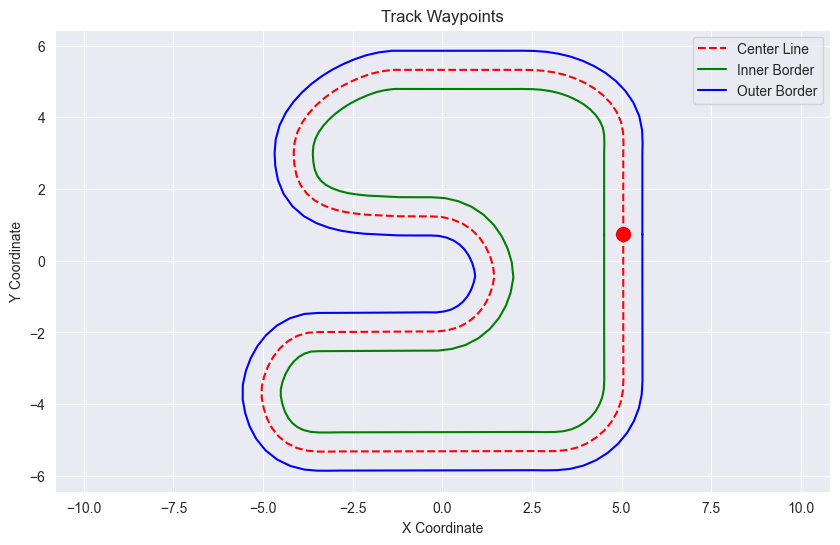

In [129]:
def plot_track(center_line, inner_border, outer_border, closest_waypoints=None):
    center_x, center_y = center_line[:, 0], center_line[:, 1]
    inner_x, inner_y = inner_border[:, 0], inner_border[:, 1]
    outer_x, outer_y = outer_border[:, 0], outer_border[:, 1]
    
    # Plot the waypoints
    plt.figure(figsize=(10, 6))
    plt.plot(center_x, center_y, 'r--', label='Center Line')
    plt.plot(inner_x, inner_y, 'g-', label='Inner Border')
    plt.plot(outer_x, outer_y, 'b-', label='Outer Border')
    
    if closest_waypoints is not None:
        closest_waypoints = [0, 1]
        plt.scatter(waypoints[closest_waypoints[0], 0], waypoints[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    
    # Add labels and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Track Waypoints')
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.axis('equal')  # Ensures equal scaling for x and y axes
    plt.show()
    
plot_track(center_line, inner_border, outer_border, closest_waypoints)

# Split Waypoints: Previous & Upcoming

In [148]:
# with the next waypoint as index, split points into two lists, previous and upcoming

def split_waypoints(points, closest_waypoints):
    # circular split list, from given closest (next) waypoint
    index = closest_waypoints[1]
    if not (0 <= index < len(points)):
        raise ValueError('index out of range')
    
    n = len(points)
    _upcoming_points: list = []
    _previous_points: list = []
    
    for i in range(index, index + (n//2)):
        _upcoming_points.append(points[i % n])
    
    for i in range(index - 1, index - 1 - (n//2), -1):
        _previous_points.append(points[i % n])
        
    return _previous_points, _upcoming_points

previous_points, upcoming_points = split_waypoints(center_line, closest_waypoints)
print('All waypoints:', len(waypoints))
print('---')
print('Previous waypoints:', len(previous_points))
print('Upcoming waypoints:', len(upcoming_points))

All waypoints: 156
---
Previous waypoints: 78
Upcoming waypoints: 78


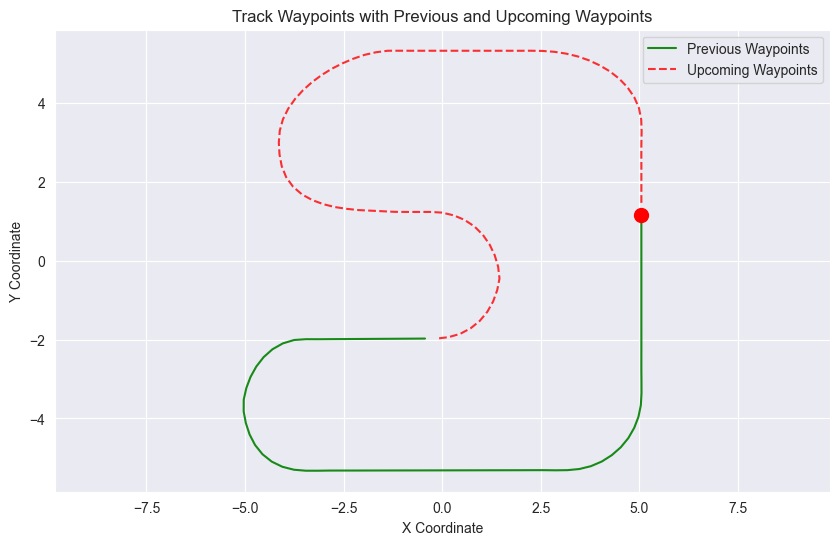

In [149]:
# plot previous and upcoming waypoints
def plot_relative_waypoints(previous_points, upcoming_points, closest_waypoints):
    plt.figure(figsize=(10, 6))
    
    # Plot all waypoints for reference
    center_x, center_y = center_line[:, 0], center_line[:, 1]
    
    # Plot previous waypoints
    previous_points = np.array(previous_points)
    plt.plot(previous_points[:, 0], previous_points[:, 1], 'g-', label='Previous Waypoints',
             markersize=6,
             alpha=0.9)
    
    # Plot upcoming waypoints
    upcoming_points = np.array(upcoming_points)
    plt.plot(upcoming_points[:, 0], upcoming_points[:, 1], 'r--', label='Upcoming Waypoints',
             markersize=5,
             alpha=0.8)
    
    # Highlight the closest waypoints (larger size)
    plt.scatter(waypoints[closest_waypoints[0], 0], waypoints[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    # plt.scatter(waypoints[closest_waypoints[1], 0], waypoints[closest_waypoints[1], 1], color='green', s=100, zorder=5)
    
    # Add labels and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Track Waypoints with Previous and Upcoming Waypoints')
    plt.legend()
    
    # Show plot
    plt.grid(True)
    plt.axis('equal')  # Ensures equal scaling for x and y axes
    plt.show()

plot_relative_waypoints(previous_points, upcoming_points, closest_waypoints)

# Identify Current Segment Type (Linear, Curve)

## ... linear segment

In [139]:
# for given points, calculate linear equality is within tolerance
def is_linear(segment, tolerance=LINEAR_TOLERANCE):
    x_coords = [point[0] for point in segment]
    y_coords = [point[1] for point in segment]
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords, rcond=None)[0]

    for x, y in zip(x_coords, y_coords):
        y_estimated = m * x + c
        if abs(y - y_estimated) > tolerance:
            return False
    return True

In [ ]:
# caution ! setting/changing tolerance can cause unintended early-exists
# iterate over waypoints, returning points within tolerance
def identify_linear_segment(previous_points, upcoming_points, tolerance=0.25):
    """
    Returns previous, upcoming and (total) current segment lists.
    """
    # init lists to store computed segment
    p_segment = []
    u_segment = []
    segment = []
    
    # check initial linear condition
    p1 = previous_points[0]
    u0 = upcoming_points[0]
    u1 = upcoming_points[1]
    init_segment = [p1, u0, u1]
    
    if not is_linear(init_segment, tolerance):
        print('Initial segment is not linear with given tolerance.')
        print('Segment:', init_segment, 'Tolerance:', tolerance)
        return np.array(p_segment), np.array(u_segment), np.array(segment)
    
    segment = init_segment

    u_segment = []
    for wp in upcoming_points:
        segment.append(wp)
        if not is_linear(segment, tolerance):
            segment.pop()
            break
        u_segment.append(wp)

    p_segment = []
    for wp in previous_points:
        segment.insert(0, wp)
        if not is_linear(segment, tolerance):
            segment.pop(0)
            break
        p_segment.insert(0, wp)
    
    
    return np.array(p_segment), np.array(u_segment), np.array(segment)

# previous, upcoming and current (total) segment lists
p_points, u_points, current_segment = identify_linear_segment(previous_points, upcoming_points)

# segment completion %
# p_completed = round(len(p_points)/len(current_segment), 3)
# p_remaining = round(len(u_points)/len(current_segment), 3)

In [169]:
# Review all points, and points in current segment, relative to current position

print('All waypoints:', len(waypoints))
print('---')
print('Previous waypoints:', len(previous_points))
print('Upcoming waypoints:', len(upcoming_points))
print()
print()

print(f'Current Segment: {len(current_segment)}')
print('---')
print(f'Previous Waypoints: {len(p_points)} ({round(len(p_points)/len(current_segment), 3)})')
print(f'Upcoming Waypoints: {len(u_points)} ({round(len(u_points)/len(current_segment), 3)})')

All waypoints: 156
---
Previous waypoints: 78
Upcoming waypoints: 78


Current Segment: 17
---
Previous Waypoints: 12 (0.706)
Upcoming Waypoints: 2 (0.118)


In [155]:
curve_entry_wp = current_segment[-1]

### Handling Output of `identify_linear_segment`

Returning a series of empty lists ? turning
Upcoming segment is an empty list ? turning

Leverage ratio of previous:upcoming points for throttle/brake incentives:
- Upcoming is high% of total segment ? +speed
- Upcoming is low% of total segment ? -speed

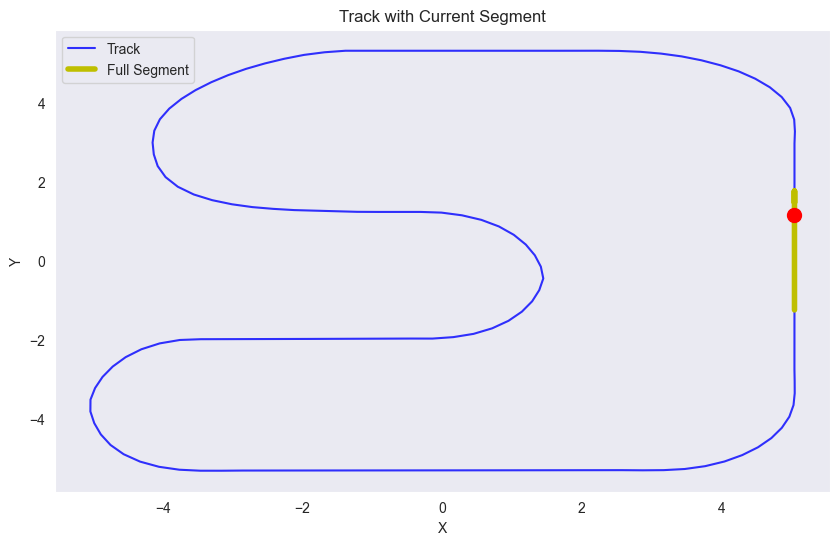

In [156]:
# plot current linear segment with track context
def plot_segment_on_track(center_line, current_segment, closest_waypoints):
    plt.figure(figsize=(10, 6))
    plt.plot(center_line[:, 0], center_line[:, 1], 'b-', label='Track',  alpha=.8)
    plt.plot(current_segment[:, 0], current_segment[:, 1], 'y-', label='Full Segment', linewidth=4, alpha=1)
    plt.scatter(center_line[closest_waypoints[0], 0], center_line[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    plt.title('Track with Current Segment')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_segment_on_track(center_line, current_segment, closest_waypoints)

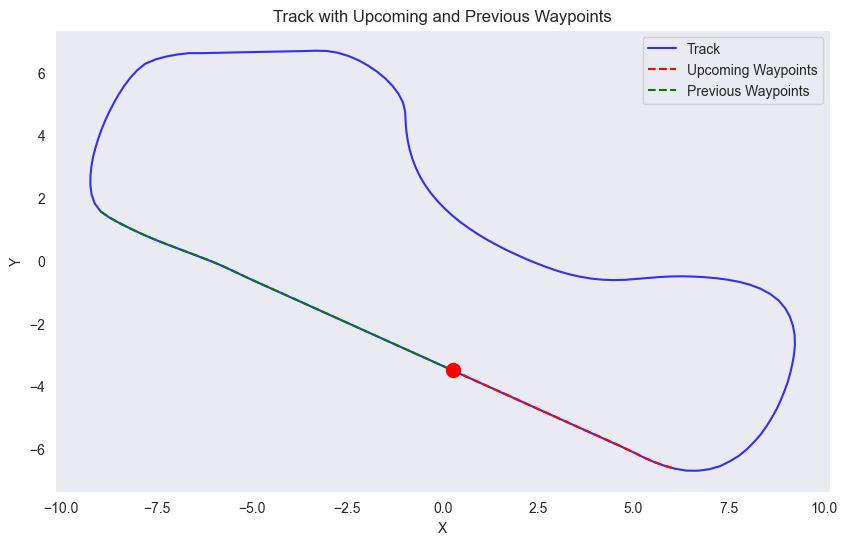

In [69]:
# plot previous/upcoming segments, relative to current position
def plot_segments_on_track(center_line, previous_segment, upcoming_segment, closest_waypoints):
    plt.figure(figsize=(10, 6))
    plt.plot(center_line[:, 0], center_line[:, 1], 'b-', label='Track',  alpha=.8)
    # plt.plot(current_segment[:, 0], current_segment[:, 1], 'y-', label='Full Segment', linewidth=4, alpha=.5)
    plt.plot(upcoming_segment[:, 0], upcoming_segment[:, 1],
             'r--',
             label='Upcoming Waypoints',
             markersize=5,
             alpha=1)
    plt.plot(previous_segment[:, 0], previous_segment[:, 1],
             'g--',
             label='Previous Waypoints',
             markersize=5,
             alpha=1)
    plt.scatter(center_line[closest_waypoints[0], 0], center_line[closest_waypoints[0], 1], color='red', s=100, zorder=5)
    plt.title('Track with Upcoming and Previous Waypoints')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid()
    plt.show()
    
plot_segments_on_track(center_line, p_points, u_points, closest_waypoints)

## ... Curved Segment

Classified Segments: 14


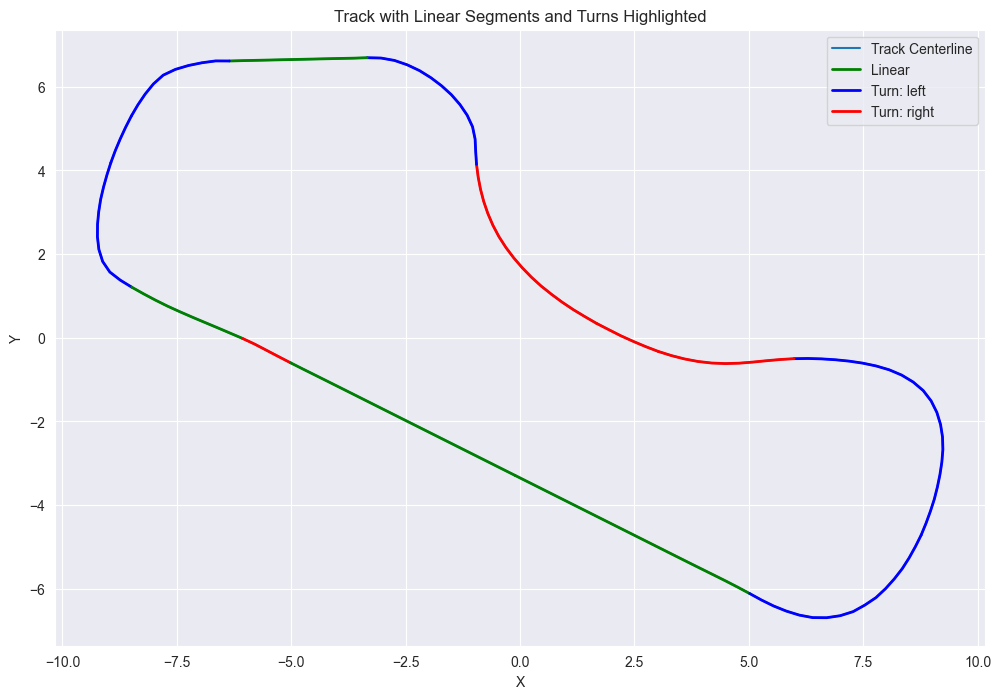

In [71]:
def identify_segments(points, linear_threshold, turn_threshold, min_linear_points=5):
    """
    Identify linear segments and turns in the track centerline.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing the track centerline.
    linear_threshold (float): Threshold for considering a segment as linear.
    turn_threshold (float): Threshold for considering a point as a part of a turn.
    min_linear_points (int): Minimum number of waypoints to consider a segment as linear.
    
    Returns:
    list of dicts: Each dictionary contains the start and end indices of a segment, 
                   the type ('linear' or 'turn'), direction ('left' or 'right' for turns), and the curvature.
    """
    segments = []

    def calculate_curvature(point1, point2, point3):
        # Calculate the curvature using three points
        a = np.linalg.norm(np.array(point1) - np.array(point2))
        b = np.linalg.norm(np.array(point2) - np.array(point3))
        c = np.linalg.norm(np.array(point3) - np.array(point1))
        if a * b * c == 0:
            return 0
        # Adding a zero z-component to the 2D vectors
        point1_3d = np.array([point1[0], point1[1], 0])
        point2_3d = np.array([point2[0], point2[1], 0])
        point3_3d = np.array([point3[0], point3[1], 0])
        return (4 * np.linalg.norm(np.cross(point2_3d - point1_3d, point3_3d - point1_3d))) / (a * b * c)

    def determine_turn_direction(point1, point2, point3):
        # Determine the direction of the turn
        point1_3d = np.array([point1[0], point1[1], 0])
        point2_3d = np.array([point2[0], point2[1], 0])
        point3_3d = np.array([point3[0], point3[1], 0])
        direction = np.cross(point2_3d - point1_3d, point3_3d - point2_3d)
        return 'left' if direction[2] > 0 else 'right'

    start_index = 0
    segment_type = 'linear'
    for i in range(1, len(points) - 1):
        curvature = calculate_curvature(points[i-1], points[i], points[i+1])
        if curvature > turn_threshold and segment_type == 'linear':
            if i - 1 > start_index and i - start_index >= min_linear_points:
                segments.append({
                    'start_index': start_index,
                    'end_index': i-1,
                    'type': 'linear',
                    'curvature': curvature
                })
                start_index = i-1
                segment_type = 'turn'
            else:
                # Merge gap into the turn
                segment_type = 'turn'
        elif curvature <= linear_threshold and segment_type == 'turn':
            if i - start_index >= min_linear_points:
                turn_direction = determine_turn_direction(points[start_index-1], points[start_index], points[i])
                segments.append({
                    'start_index': start_index,
                    'end_index': i-1,
                    'type': 'turn',
                    'direction': turn_direction,
                    'curvature': curvature
                })
                start_index = i-1
                segment_type = 'linear'
            else:
                # Merge gap into the turn
                segment_type = 'turn'

    # Handle the last segment
    if start_index < len(points) - 1:
        segment_curvature = calculate_curvature(points[start_index-1], points[start_index], points[-1]) if start_index > 0 else 0
        segments.append({
            'start_index': start_index,
            'end_index': len(points) - 1,
            'type': segment_type,
            'curvature': segment_curvature
        })

    return segments


def plot_segments(points, segments):
    """
    Plot the track and highlight linear segments and turns.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing the track centerline.
    segments (list of dicts): List of segments identified in the track.
    """
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    plt.figure(figsize=(12, 8))
    plt.plot(x_coords, y_coords, label='Track Centerline')

    for segment in segments:
        start_idx = segment['start_index']
        end_idx = segment['end_index']
        segment_x = x_coords[start_idx:end_idx+1]
        segment_y = y_coords[start_idx:end_idx+1]
        if segment['type'] == 'turn':
            color = 'red' if segment['direction'] == 'right' else 'blue'
            plt.plot(segment_x, segment_y, color=color, linewidth=2, label=f"Turn: {segment['direction']}")
        else:
            plt.plot(segment_x, segment_y, color='green', linewidth=2, label="Linear")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Track with Linear Segments and Turns Highlighted')
    plt.grid(True)
    plt.show()


classified_segments = identify_segments(center_line, 0.25, 0.25, min_linear_points=5)
print('Classified Segments:', len(classified_segments))
plot_segments(center_line, classified_segments)

In [80]:
def calculate_optimal_racing_line(points, segments, track_width):
    """
    Calculate the optimal racing line based on identified segments.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing the track centerline.
    segments (list of dicts): List of segments identified in the track.
    track_width (float): Width of the track.
    
    Returns:
    list of tuples: List of (x, y) coordinates representing the optimal racing line.
    """
    optimal_line = []

    def interpolate_point(p1, p2, fraction):
        return (p1[0] + fraction * (p2[0] - p1[0]), p1[1] + fraction * (p2[1] - p1[1]))

    for segment in segments:
        start_idx = segment['start_index']
        end_idx = segment['end_index']
        if segment['type'] == 'linear':
            # For linear segments, stay close to the centerline
            optimal_line.extend(points[start_idx:end_idx+1])
        else:
            # For turns, use the out-in-out strategy
            turn_points = points[start_idx:end_idx+1]
            if len(turn_points) < 3:
                # Not enough points to form a turn, treat as linear
                optimal_line.extend(turn_points)
                continue

            apex_idx = (start_idx + end_idx) // 2

            # Out point (start of the turn)
            out_start = interpolate_point(turn_points[0], turn_points[1], 0.5)
            # Apex point
            apex = interpolate_point(turn_points[apex_idx-start_idx-1], turn_points[apex_idx-start_idx], 0.5)
            # Out point (end of the turn)
            out_end = interpolate_point(turn_points[-2], turn_points[-1], 0.5)

            optimal_line.append(out_start)
            optimal_line.append(apex)
            optimal_line.append(out_end)

    # Spline interpolation for smoothing the optimal line
    if len(optimal_line) > 3:
        optimal_x_coords = [point[0] for point in optimal_line]
        optimal_y_coords = [point[1] for point in optimal_line]

        tck, u = splprep([optimal_x_coords, optimal_y_coords], s=0)
        unew = np.linspace(0, 1, num=len(optimal_line) * 10)  # Increase the number of points for a smoother curve
        smooth_coords = splev(unew, tck)

        optimal_line = list(zip(smooth_coords[0], smooth_coords[1]))

    return optimal_line

optimal_line = calculate_optimal_racing_line(center_line, classified_segments, track_width=TRACK_WIDTH)

In [104]:
def calculate_optimal_racing_line_between_borders(points, segments, internal_border, external_border, track_width):
    """
    Calculate the optimal racing line based on identified segments.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing the track centerline.
    segments (list of dicts): List of segments identified in the track.
    internal_border (list of tuples): List of (x, y) coordinates representing the internal border of the track.
    external_border (list of tuples): List of (x, y) coordinates representing the external border of the track.
    track_width (float): Width of the track.
    
    Returns:
    list of tuples: List of (x, y) coordinates representing the optimal racing line.
    """
    optimal_line = []
    def calculate_curvature(point1, point2, point3):
        """
        Calculate the curvature given three points.
        
        Parameters:
        point1, point2, point3 (tuple): Points representing (x, y) coordinates.
        
        Returns:
        float: Curvature value.
        """
        a = np.linalg.norm(np.array(point1) - np.array(point2))
        b = np.linalg.norm(np.array(point2) - np.array(point3))
        c = np.linalg.norm(np.array(point3) - np.array(point1))
        if a * b * c == 0:
            return 0
        # Adding a zero z-component to the 2D vectors
        point1_3d = np.array([point1[0], point1[1], 0])
        point2_3d = np.array([point2[0], point2[1], 0])
        point3_3d = np.array([point3[0], point3[1], 0])
        return (4 * np.linalg.norm(np.cross(point2_3d - point1_3d, point3_3d - point1_3d))) / (a * b * c)


    def interpolate_point(p1, p2, fraction):
        return (p1[0] + fraction * (p2[0] - p1[0]), p1[1] + fraction * (p2[1] - p1[1]))
    
    def weighted_point(internal, external, weight):
        return (internal[0] * (1 - weight) + external[0] * weight,
                internal[1] * (1 - weight) + external[1] * weight)
    
    def is_mostly_straight(segment):
        # Determine if a segment is mostly straight by checking the total curvature
        total_curvature = 0
        for i in range(segment['start_index'] + 1, segment['end_index']):
            total_curvature += calculate_curvature(points[i-1], points[i], points[i+1])
        return total_curvature < (segment['end_index'] - segment['start_index']) * 0.01  # Threshold for mostly straight
    
    for segment in segments:
        start_idx = segment['start_index']
        end_idx = segment['end_index']
        if segment['type'] == 'linear' or is_mostly_straight(segment):
            # For linear segments, stay close to the centerline
            optimal_line.extend(points[start_idx:end_idx+1])
        else:
            # For turns, use the out-in-out strategy with 80% of the track width
            turn_points = points[start_idx:end_idx+1]
            if len(turn_points) < 3:
                # Not enough points to form a turn, treat as linear
                optimal_line.extend(turn_points)
                continue
    
            apex_idx = (start_idx + end_idx) // 2
    
            # Out point (start of the turn)
            out_start = weighted_point(internal_border[start_idx], external_border[start_idx], 0.2)
            # Apex point
            apex = weighted_point(internal_border[apex_idx], external_border[apex_idx], 0.3)
            # Out point (end of the turn)
            out_end = weighted_point(internal_border[end_idx], external_border[end_idx], 0.4)
    
            optimal_line.append(out_start)
            optimal_line.append(apex)
            optimal_line.append(out_end)
    
    # Spline interpolation for smoothing the optimal line
    if len(optimal_line) > 3:
        optimal_x_coords = [point[0] for point in optimal_line]
        optimal_y_coords = [point[1] for point in optimal_line]
    
        tck, u = splprep([optimal_x_coords, optimal_y_coords], s=0)
        unew = np.linspace(0, 1, num=len(optimal_line) * 10)  # Increase the number of points for a smoother curve
        smooth_coords = splev(unew, tck)
    
        optimal_line = list(zip(smooth_coords[0], smooth_coords[1]))
    
    return optimal_line

optimal_line_between_borders = calculate_optimal_racing_line_between_borders(center_line, classified_segments, inner_border, outer_border, TRACK_WIDTH)

In [106]:
def plot_racing_line(points, optimal_line):
    """
    Plot the original track centerline and the optimal racing line.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing the track centerline.
    optimal_line (list of tuples): List of (x, y) coordinates representing the optimal racing line.
    """
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    optimal_x_coords = [point[0] for point in optimal_line]
    optimal_y_coords = [point[1] for point in optimal_line]

    plt.figure(figsize=(12, 8))
    plt.plot(x_coords, y_coords, label='Track Centerline', color='gray')
    plt.plot(optimal_x_coords, optimal_y_coords, label='Optimal Racing Line', color='red', linestyle='--')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Track with Optimal Racing Line Highlighted')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_racing_line_between_borders(points, optimal_line_bb, internal_border, external_border):
    """
    Plot the original track centerline, borders, and the optimal racing line.
    
    Parameters:
    points (list of tuples): List of (x, y) coordinates representing the track centerline.
    optimal_line (list of tuples): List of (x, y) coordinates representing the optimal racing line.
    internal_border (list of tuples): List of (x, y) coordinates representing the internal border of the track.
    external_border (list of tuples): List of (x, y) coordinates representing the external border of the track.
    """
    x_coords = [point[0] for point in points]
    y_coords = [point[1] for point in points]

    optimal_x_coords = [point[0] for point in optimal_line_bb]
    optimal_y_coords = [point[1] for point in optimal_line_bb]

    internal_x_coords = [point[0] for point in internal_border]
    internal_y_coords = [point[1] for point in internal_border]

    external_x_coords = [point[0] for point in external_border]
    external_y_coords = [point[1] for point in external_border]

    plt.figure(figsize=(12, 8))
    plt.plot(x_coords, y_coords, label='Track Centerline', color='gray')
    plt.plot(internal_x_coords, internal_y_coords, label='Internal Border', color='blue', linestyle='--')
    plt.plot(external_x_coords, external_y_coords, label='External Border', color='green', linestyle='--')
    plt.plot(optimal_x_coords, optimal_y_coords, label='Optimal Racing Line', color='red', linestyle='--')

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Track with Optimal Racing Line Highlighted')
    plt.legend()
    plt.grid(True)
    plt.show()

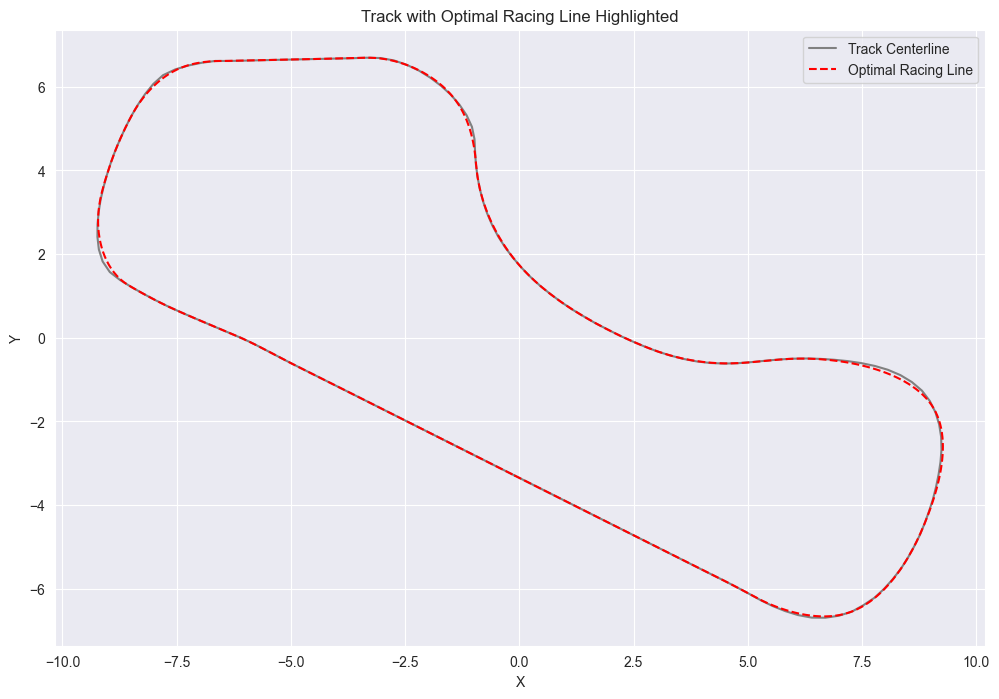

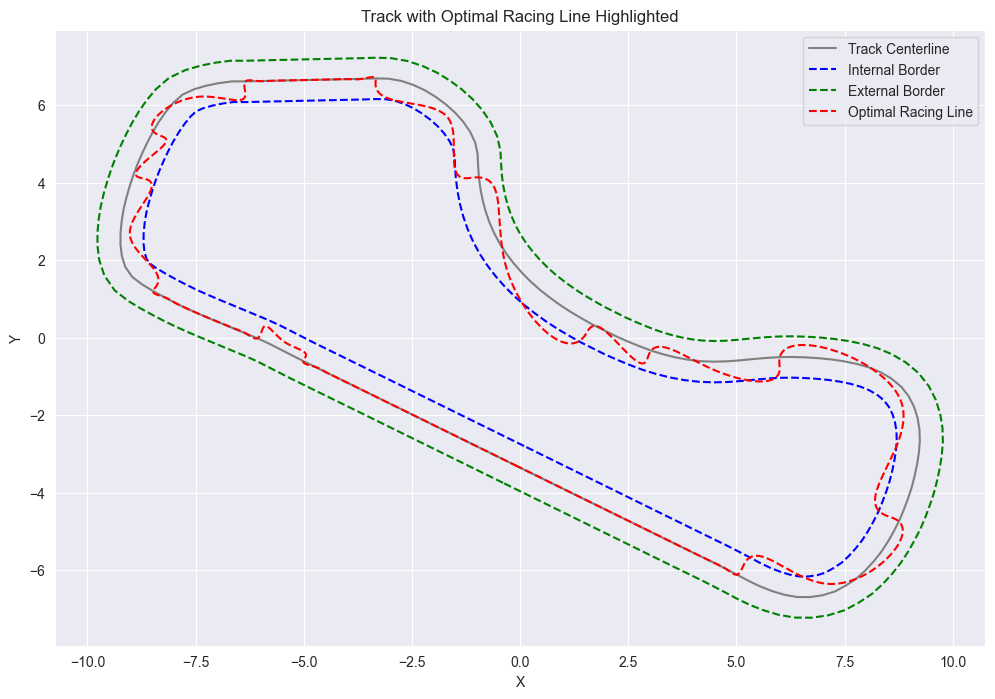

In [107]:

plot_racing_line(center_line, optimal_line)
plot_racing_line_between_borders(center_line, optimal_line_between_borders, inner_border, outer_border)


In [110]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [120]:
# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=8 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=1000 # default 1000

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

In [157]:
print(len(center_line))
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border, outer_border)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r", flush=True)

156


In [122]:
# for april open ccw
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % LineString(center_line).length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)


These should be the same:  ((170, 2), (170, 2))
Original centerline length: 50.28
New race line length: 47.51


In [158]:
# for may open ccw
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % LineString(center_line).length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

These should be the same:  ((156, 2), (156, 2))
Original centerline length: 46.12
New race line length: 41.27


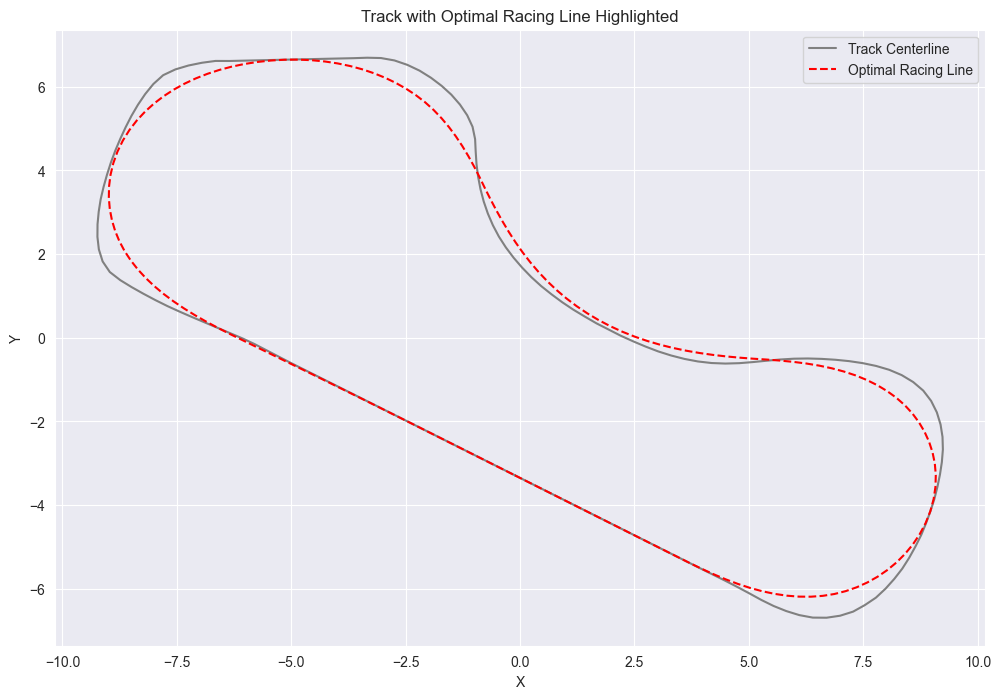

In [124]:
# for april open ccw
plot_racing_line(center_line, loop_race_line)

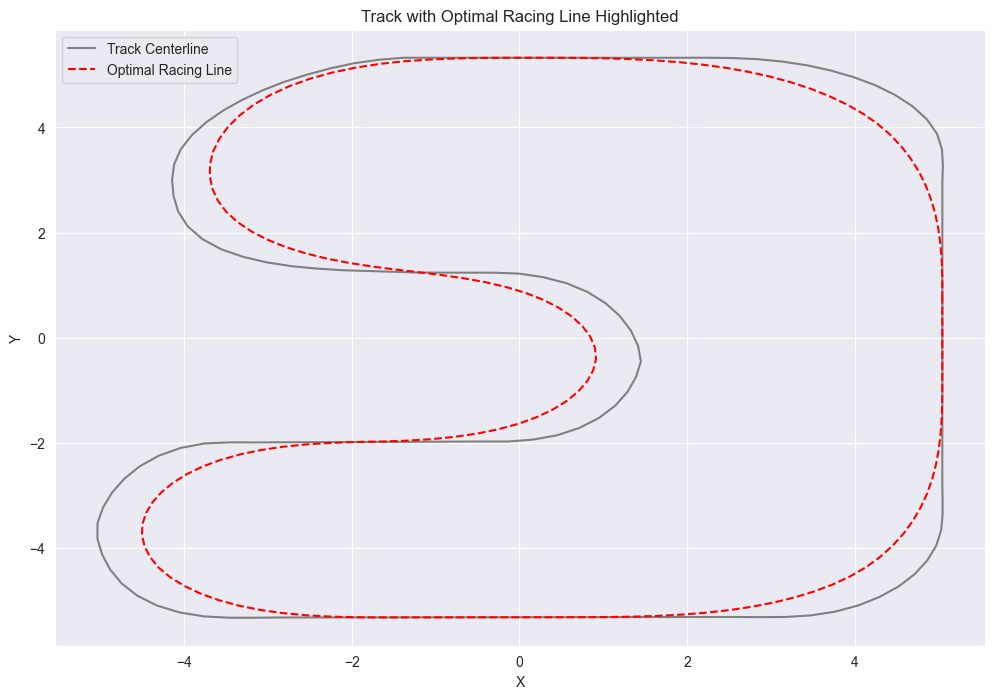

In [159]:
# for may open ccw
plot_racing_line(center_line, loop_race_line)

In [166]:
loop_race_line

array([[ 5.04771315,  0.73385354],
       [ 5.04770565,  0.86385354],
       [ 5.04752488,  1.00379612],
       [ 5.04601829,  1.20414345],
       [ 5.03994307,  1.47311557],
       [ 5.02600116,  1.76191145],
       [ 5.00189401,  2.05172213],
       [ 4.96582171,  2.33698581],
       [ 4.91622468,  2.61553037],
       [ 4.85177041,  2.88595332],
       [ 4.77133984,  3.14700389],
       [ 4.67395059,  3.39739714],
       [ 4.55875699,  3.6357692 ],
       [ 4.42492216,  3.86054687],
       [ 4.27168295,  4.06991523],
       [ 4.09820469,  4.26155308],
       [ 3.90671749,  4.43574428],
       [ 3.69902421,  4.5927325 ],
       [ 3.47672521,  4.73282678],
       [ 3.24119441,  4.85629389],
       [ 2.99367483,  4.96340414],
       [ 2.7353805 ,  5.05453931],
       [ 2.46749674,  5.1301884 ],
       [ 2.19125568,  5.19108411],
       [ 1.90793165,  5.23825206],
       [ 1.61880839,  5.2730189 ],
       [ 1.32512922,  5.29697578],
       [ 1.02804748,  5.3119132 ],
       [ 0.72859687,

In [164]:
now = datetime.now()
prefix = './racelines/%s-%d-%d-%s' % (TRACK_NAME, LINE_ITERATIONS, XI_ITERATIONS, now.strftime('%Y-%m-%d-%H%M%S'))
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))

print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to ./racelines/2022_may_open_ccw-1000-8-2024-08-01-220319.py
Writing numpy binary to ./racelines/2022_may_open_ccw-1000-8-2024-08-01-220319.npy


In [ ]:
# load existing raceline
fname = './racelines/ChampionshipCup2019_track-15000-8-2020-05-19-140701.py'
with open(fname, "r") as file:
    deserialized = eval(file.read())
# deserialized
# fig = plt.figure(1, figsize=(16, 10))
# ax = fig.add_subplot(111, facecolor='black')
# plt.axis('equal')
# print_border(ax, deserialized, inner_border, outer_border)